# Add a new technology “gas power plant”

- Assume realistic cost parameters and lifetimes for this power plant type (include references your sources in the notebook)
- Is there a “sweet spot” of prices on carbon such that coal, wind & gas are used at the same time?

## Introduction

Since gas power plant is usually supplied with gas we include this within the O&M costs, because we do not want to introduce a whole new fuel type.

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [42]:
mp = ixmp.Platform()

### Making a clone of the existing scenario 'baseline'

Loading the existing scenario 'baseline' and cloning to a new scenario 'gas_ppl' to add the gas power plant

In [43]:
model = 'Westeros Electrified'
base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'gas_ppl', 'introduce new gas power plant', keep_solution=False)
scen.check_out()

In [44]:
country = 'Westeros'
model_horizon = scen.set('year')
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

### Create gas power plant

In [45]:
scen.add_set("technology", 'gas_ppl')

In [46]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_output = make_df(base, node_dest=country, time_dest='year')

gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity', 
                   level='secondary', value=1., unit="GWa")
scen.add_par('output', gas_out)

### Operational Constraints and Parameters

Include Capacity factor of 1.0

In [47]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

gas_capacity = 1.0

df = make_df(base_capacity_factor, technology='gas_ppl', value=gas_capacity)
scen.add_par('capacity_factor', df)

Include lifetime same as coal = 20

In [48]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

df = make_df(base_technical_lifetime, technology='gas_ppl', value=20)
scen.add_par('technical_lifetime', df)

### Technological Diffusion and Contraction

In [49]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

df = make_df(base_growth, technology='gas_ppl', value=0.1) 
scen.add_par('growth_activity_up', df)

### Defining an Energy Mix
Gas has the same fraction as coal

In [50]:
history = [690]

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

demand_per_year = 40 * 12 * 1000 / 8760
historic_demand = 0.85 * demand_per_year
grid_efficiency = 0.9
historic_generation = historic_demand / grid_efficiency
gas_fraction = 0.6
gas_activity = (1 - gas_fraction) * historic_generation

df = make_df(base_activity, technology='gas_ppl', value=gas_activity)
scen.add_par('historical_activity', df)

In [51]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

gas_cap = 1 / 10 / gas_capacity / 2
    
value = gas_activity * gas_cap
df = make_df(base_capacity, technology='gas_ppl', value=value)
scen.add_par('historical_new_capacity', df)

### Investment costs
| technology | USD/kw |
|---------------|--------------|
| Coal     | 500    |
| Wind     | 1500        |
| Bulb     | 5   |
| Gas     | 750         |

In [52]:
# in $ / kW (specific investment cost)
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

df = make_df(base_inv_cost, technology='gas_ppl', value=750)
scen.add_par('inv_cost', df)

### Fixed O&M Costs
| technology | USD/kw |
|---------------|--------------|
| Coal     | 30    |
| Wind     | 10        |
| Gas     | 25         |

In [53]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

df = make_df(base_fix_cost, technology='gas_ppl', value=25)
scen.add_par('fix_cost', df)

### Variable O&M Costs

| technology | USD/kw |
|---------------|--------------|
| Coal     | 30    |
| Gas     | 40         |

In [54]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

In [55]:
df = make_df(base_var_cost, technology='gas_ppl', value=40)
scen.add_par('var_cost', df)

## Run model

In [56]:
scen.commit(comment='introducing gas power plant')

In [57]:
scen.solve()

In [58]:
scen.var('OBJ')['lvl']

320619.40625

In [75]:
scen.var_list()

['OBJ',
 'EXT',
 'STOCK',
 'CAP_NEW',
 'CAP',
 'ACT',
 'EMISS',
 'LAND',
 'REL',
 'DEMAND',
 'PRICE_COMMODITY',
 'PRICE_EMISSION',
 'COST_NODAL',
 'COST_NODAL_NET',
 'GDP',
 'I',
 'C']

## Results

In [65]:
# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
from message_ix.reporting import Reporter

rep = Reporter.from_scenario(scen)

# Add keys like "plot activity" to describe reporting operations.
# See tutorial/utils/plotting.py
from message_ix.util.tutorial import prepare_plots

prepare_plots(rep)

### Activity
How much energy is generated in each time period from the different potential sources?

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

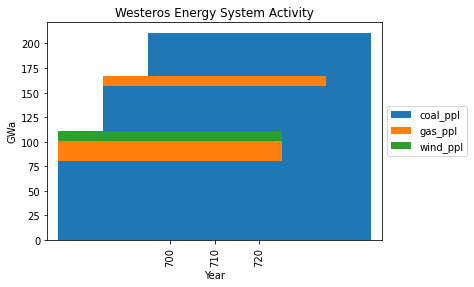

In [68]:
# Only show a subset of technologies in the follow plots;
# e.g. exclude "bulb" and "grid"
rep.set_filters(t=["coal_ppl", "wind_ppl", "gas_ppl"])

# Trigger the calculation and plotting
rep.get("plot activity")

In [128]:
activity = scen.var('ACT')
activity

,node_loc,technology,year_vtg,year_act,mode,time,lvl,mrg
0,Westeros,coal_ppl,690,700,standard,year,15.525114,0.000000
1,Westeros,coal_ppl,700,700,standard,year,65.011181,0.000000
2,Westeros,coal_ppl,700,710,standard,year,65.011181,0.000000
3,Westeros,coal_ppl,710,710,standard,year,91.780822,0.000000
4,Westeros,coal_ppl,710,720,standard,year,91.780822,0.000000
5,Westeros,coal_ppl,720,720,standard,year,119.330289,0.000000
6,Westeros,wind_ppl,690,700,standard,year,10.350076,0.000000
7,Westeros,wind_ppl,700,700,standard,year,0.000000,0.000000
8,Westeros,wind_ppl,700,710,standard,year,0.000000,0.000000
9,Westeros,wind_ppl,710,710,standard,year,0.000000,0.000000


In [129]:
print('Coal:', activity.loc[activity['technology'] == 'coal_ppl']['lvl'].sum())
print('Wind:', activity.loc[activity['technology'] == 'wind_ppl']['lvl'].sum())
print('Gas:', activity.loc[activity['technology'] == 'gas_ppl']['lvl'].sum())

Coal: 448.439410003166
Wind: 10.350076103500761
Gas: 30.09940278222215


### Capacity
How much capacity of each plant is installed in each period?

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

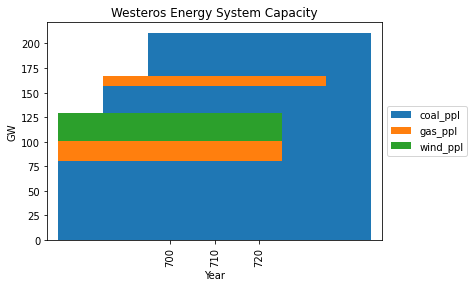

In [67]:
# Create a different plot. The same filters are still active.
rep.get("plot capacity")

In [123]:
capacity = scen.var('CAP')
capacity

,node_loc,technology,year_vtg,year_act,lvl,mrg
0,Westeros,coal_ppl,690,700,15.525114,0.000000
1,Westeros,coal_ppl,700,700,65.011181,0.000000
2,Westeros,coal_ppl,700,710,65.011181,0.000000
3,Westeros,coal_ppl,710,710,91.780822,0.000000
4,Westeros,coal_ppl,710,720,91.780822,0.000000
5,Westeros,coal_ppl,720,720,119.330289,0.000000
6,Westeros,wind_ppl,690,700,28.750211,0.000000
7,Westeros,wind_ppl,700,700,0.000000,782.779778
8,Westeros,wind_ppl,700,710,0.000000,0.000000
9,Westeros,wind_ppl,710,710,0.000000,536.994448


In [125]:
print('Coal:', capacity.loc[capacity['technology'] == 'coal_ppl']['lvl'].sum())
print('Wind:', capacity.loc[capacity['technology'] == 'wind_ppl']['lvl'].sum())
print('Gas:', capacity.loc[capacity['technology'] == 'gas_ppl']['lvl'].sum())

Coal: 448.439410003166
Wind: 28.750211398613228
Gas: 30.09940278222215


### New Capacity
How much new capacity of each plant is installed overall?

In [130]:
new_capacity = scen.var('CAP_NEW')
new_capacity

,node_loc,technology,year_vtg,lvl,mrg
0,Westeros,coal_ppl,700,6.501118,0.0
1,Westeros,coal_ppl,710,9.178082,0.0
2,Westeros,coal_ppl,720,11.933029,0.0
3,Westeros,wind_ppl,700,0.000000,0.0
4,Westeros,wind_ppl,710,0.000000,0.0
5,Westeros,wind_ppl,720,0.000000,0.0
6,Westeros,bulb,700,100.000000,0.0
7,Westeros,bulb,710,150.000000,0.0
8,Westeros,bulb,720,190.000000,0.0
9,Westeros,gas_ppl,700,0.987466,0.0


In [131]:
print('Coal:', new_capacity.loc[new_capacity['technology'] == 'coal_ppl']['lvl'].sum())
print('Wind:', new_capacity.loc[new_capacity['technology'] == 'wind_ppl']['lvl'].sum())
print('Gas:', new_capacity.loc[new_capacity['technology'] == 'gas_ppl']['lvl'].sum())

Coal: 27.61222925206089
Wind: 0.0
Gas: 0.9874663339360694


## Conclusions
The total costs are decreasing, since with the additional gas power plant there is more freedom and possibility to meet the energy demand. Furthermore, it can be observed that all technologies are at least used.
Secondly, the major energy part is generated out of coal which is problematic, especially when there is no new wind power plants built during the decades.
We will tackle this issue within the next notebook by introducing an invention of Eddard Stark, namely carbon prices.

## Close connection to database

In [132]:
mp.close_db()